In [52]:

import os
from glob import glob

DATASET_DIR = "cv_project_folder/shader_data/SHADER-r1_1"  

def check_shader_dataset(root):
    batch_folders = sorted(glob(os.path.join(root, "*Batch*")))
    if not batch_folders:
        print(" No batch folders found! Check DATASET_DIR path.")
        return
    
    total_samples = 0
    total_frames = 0

    print(f" Root: {root}")
    print(f" Found {len(batch_folders)} batch folders.\n")

    # loop through batches
    for b, batch in enumerate(batch_folders):
        subject_folders = sorted(glob(os.path.join(batch, "*")))
        if not subject_folders:
            continue
        print(f" {os.path.basename(batch)} — {len(subject_folders)} subjects")

        # check only first few subjects to avoid huge prints
        for s, subj in enumerate(subject_folders[:2]):
            dressed_imgs = sorted(glob(os.path.join(subj, "dressed", "Image*.png")))
            naked_imgs = sorted(glob(os.path.join(subj, "naked", "Image*.png")))
            gt_files = glob(os.path.join(subj, "gt*.pkl"))

            print(f"   Subject: {os.path.basename(subj)}")
            print(f"       Dressed images: {len(dressed_imgs)}")
            print(f"       Naked images:   {len(naked_imgs)}")
            print(f"       GT files:       {len(gt_files)}\n")

            total_samples += 1
            total_frames += len(dressed_imgs)

    print(" Structure check complete!")
    print(f" Total batches: {len(batch_folders)}")
    print(f" Total sample subjects (checked): {total_samples}")
    print(f" Total frames (approx): {total_frames}")
    print("\nNext: we will sample one subject to generate silhouette confidence maps (STEP 2).")

check_shader_dataset(DATASET_DIR)


 Root: cv_project_folder/shader_data/SHADER-r1_1
 Found 30 batch folders.

 femaleBatch001 — 29 subjects
   Subject: 0000
       Dressed images: 200
       Naked images:   200
       GT files:       1

   Subject: 0001
       Dressed images: 200
       Naked images:   200
       GT files:       1

 femaleBatch002 — 28 subjects
   Subject: 0000
       Dressed images: 200
       Naked images:   200
       GT files:       1

   Subject: 0003
       Dressed images: 200
       Naked images:   200
       GT files:       1

 femaleBatch003 — 16 subjects
   Subject: 0000
       Dressed images: 200
       Naked images:   200
       GT files:       1

   Subject: 0004
       Dressed images: 200
       Naked images:   200
       GT files:       1

 femaleBatch004 — 35 subjects
   Subject: 0000
       Dressed images: 200
       Naked images:   200
       GT files:       1

   Subject: 0003
       Dressed images: 200
       Naked images:   200
       GT files:       1

 femaleBatch005 — 30 subjects

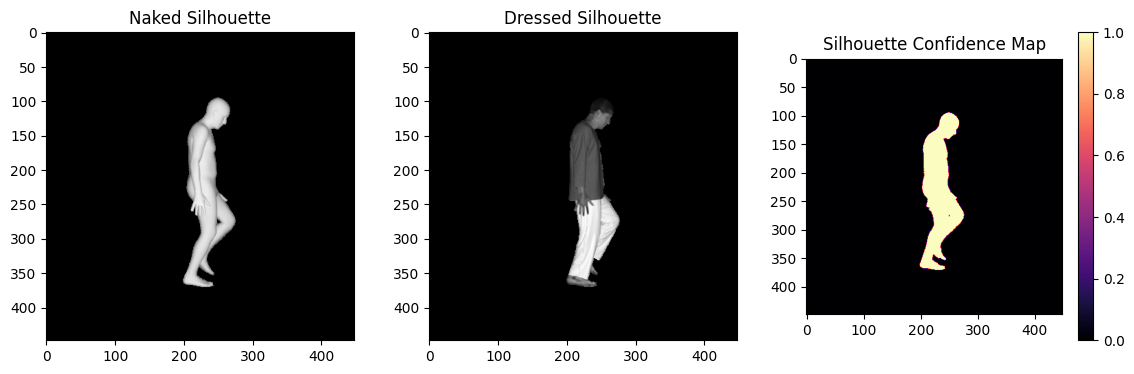

 STEP 2 complete — Silhouette confidence map generated successfully.
Next: we’ll train the Hourglass network to predict these maps (STEP 3).


In [53]:
# STEP 2: GENERATE SILHOUETTE CONFIDENCE MAPS (Eq. 1–2) 

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from PIL import Image
import os, math

# Gaussian-based silhouette confidence computation
def compute_silhouette_confidence(naked_mask, dressed_mask, sigma_conf=1.0):
    """Implements Eq.(1)–(2) from the SHADER paper."""
    naked = (naked_mask > 0).astype(np.uint8)
    dressed = (dressed_mask > 0).astype(np.uint8)
    confidence = np.zeros_like(naked, dtype=np.float32)

    # Inside naked silhouette -> 1.0
    confidence[naked == 1] = 1.0

    # Identify clothing region
    cloth = (dressed == 1) & (naked == 0)
    if cloth.sum() == 0:
        return confidence

    # Distance from each pixel in cloth region to nearest body pixel
    inv_body = 1 - naked
    dist_map = ndi.distance_transform_edt(inv_body)
    distances = dist_map[cloth]

    # Gaussian decay
    factor = 1.0 / (math.sqrt(2 * math.pi) * sigma_conf)
    vals = factor * np.exp(-(distances ** 2) / (2 * (sigma_conf ** 2)))
    vals /= vals.max()
    conf_map = confidence.copy()
    conf_map[cloth] = np.clip(vals, 0.0, 1.0)
    return conf_map


SAMPLE_SUBJECT = "0000"      
SAMPLE_FRAME   = "Image0000"
BATCH_FOLDER   = "maleBatch001"  

# Build paths
base_path = os.path.join(DATASET_DIR, BATCH_FOLDER, SAMPLE_SUBJECT)
naked_path   = os.path.join(base_path, "naked",   f"{SAMPLE_FRAME}.png")
dressed_path = os.path.join(base_path, "dressed", f"{SAMPLE_FRAME}.png")

# Load images
naked_img   = np.array(Image.open(naked_path).convert("L"))
dressed_img = np.array(Image.open(dressed_path).convert("L"))

# Compute confidence map
conf_map = compute_silhouette_confidence(naked_img, dressed_img, sigma_conf=1.0)


plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(naked_img, cmap='gray'); plt.title("Naked Silhouette")
plt.subplot(1,3,2); plt.imshow(dressed_img, cmap='gray'); plt.title("Dressed Silhouette")
plt.subplot(1,3,3); plt.imshow(conf_map, cmap='magma'); plt.title("Silhouette Confidence Map"); plt.colorbar()
plt.show()

print(" STEP 2 complete — Silhouette confidence map generated successfully.")
print("Next: we’ll train the Hourglass network to predict these maps (STEP 3).")


In [54]:
# Hourglass with size-matched upsampling (prevents odd-dimension mismatches)
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import os, math, time
from torch.utils.data import Dataset, DataLoader

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        mid = out_ch // 2
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, mid, 1, bias=False),
            nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
            nn.Conv2d(mid, mid, 3, padding=1, bias=False),
            nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
            nn.Conv2d(mid, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )
        self.skip = (
            nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, bias=False),
                          nn.BatchNorm2d(out_ch))
            if in_ch != out_ch else nn.Identity()
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.block(x) + self.skip(x))

class HourglassFixed(nn.Module):
    def __init__(self, depth, n_feats):
        super().__init__()
        self.depth = depth; self.n_feats = n_feats
        self._make_layers(depth)

    def _make_layers(self, depth):
        self.add_module(f'res{depth}_1', ResidualBlock(self.n_feats, self.n_feats))
        self.add_module(f'pool{depth}', nn.MaxPool2d(2, ceil_mode=False))
        if depth > 1:
            self._make_layers(depth - 1)
        else:
            self.add_module('res_bottom', ResidualBlock(self.n_feats, self.n_feats))
        self.add_module(f'res{depth}_2', ResidualBlock(self.n_feats, self.n_feats))

    def _forward(self, x, depth):
        up1 = getattr(self, f'res{depth}_1')(x)
        low1 = getattr(self, f'pool{depth}')(x)
        if depth > 1:
            low2 = self._forward(low1, depth-1)
        else:
            low2 = getattr(self, 'res_bottom')(low1)
        low3 = getattr(self, f'res{depth}_2')(low2)
        up2 = F.interpolate(low3, size=up1.shape[-2:], mode='nearest')
        return up1 + up2

    def forward(self, x): return self._forward(x, self.depth)

# HourglassStack using HourglassFixed
class HourglassStackFixed(nn.Module):
    def __init__(self, num_stacks=6, n_feats=256):
        super().__init__()
        self.num_stacks = num_stacks
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64); self.relu = nn.ReLU(inplace=True)
        self.res1 = ResidualBlock(64,128); self.pool = nn.MaxPool2d(2)
        self.res2 = ResidualBlock(128,128); self.res3 = ResidualBlock(128,n_feats)
        self.hgs = nn.ModuleList([HourglassFixed(4,n_feats) for _ in range(num_stacks)])
        self.res = nn.ModuleList([ResidualBlock(n_feats,n_feats) for _ in range(num_stacks)])
        self.lin = nn.ModuleList([nn.Sequential(nn.Conv2d(n_feats,n_feats,1,bias=False),
                                                nn.BatchNorm2d(n_feats), nn.ReLU(inplace=True))
                                  for _ in range(num_stacks)])
        self.outs = nn.ModuleList([nn.Conv2d(n_feats,2,1) for _ in range(num_stacks)])
        self.remap_out = nn.ModuleList([nn.Conv2d(2,n_feats,1) for _ in range(num_stacks)])
        self.remap_lin = nn.ModuleList([nn.Conv2d(n_feats,n_feats,1) for _ in range(num_stacks-1)])
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.res1(x); x = self.pool(x); x = self.res2(x); x = self.res3(x)
        inter = x; outs=[]
        for i in range(self.num_stacks):
            hg = self.hgs[i](inter); res = self.res[i](hg); lin = self.lin[i](res)
            out = self.outs[i](lin); outs.append(out)
            if i < self.num_stacks-1:
                inter = inter + self.remap_out[i](out) + self.remap_lin[i](lin)
        return outs

# small dataset elper (reuse compute_silhouette_confidence from earlier)
def compute_silhouette_confidence(naked_mask, dressed_mask, sigma_conf=1.0):
    import numpy as np, math
    from scipy import ndimage as ndi
    naked = (naked_mask > 0).astype(np.uint8)
    dressed = (dressed_mask > 0).astype(np.uint8)
    confidence = np.zeros_like(naked, dtype=np.float32)
    confidence[naked == 1] = 1.0
    cloth = (dressed == 1) & (naked == 0)
    if cloth.sum() == 0:
        return confidence
    inv_body = 1 - naked
    dist_map = ndi.distance_transform_edt(inv_body)
    distances = dist_map[cloth]
    factor = 1.0 / (math.sqrt(2 * math.pi) * sigma_conf)
    vals = factor * np.exp(-(distances ** 2) / (2 * (sigma_conf ** 2)))
    vals /= vals.max()
    conf_map = confidence.copy()
    conf_map[cloth] = np.clip(vals, 0.0, 1.0)
    return conf_map

# Minimal dataset class (small sample set) 
class ShaderMiniDataset(Dataset):
    def __init__(self, root, max_samples=64 , image_size=224):
        self.samples=[]
        batches = sorted([b for b in os.listdir(root) if "Batch" in b])
        for b in batches:
            subjects = sorted(os.listdir(os.path.join(root,b)))
            for subj in subjects:
                dpath=os.path.join(root,b,subj,"dressed")
                npath=os.path.join(root,b,subj,"naked")
                if not os.path.exists(dpath) or not os.path.exists(npath): continue
                dressed_imgs=sorted([f for f in os.listdir(dpath) if f.endswith('.png')])
                for imgname in dressed_imgs[:max_samples]:
                    self.samples.append((os.path.join(dpath,imgname),
                                         os.path.join(npath,imgname)))
        self.image_size=image_size
        print(f" Loaded {len(self.samples)} samples.")
    def __len__(self): return len(self.samples)
    def __getitem__(self,idx):
        d_img,n_img=self.samples[idx]
        d=np.array(Image.open(d_img).convert('L').resize((self.image_size,self.image_size)))
        n=np.array(Image.open(n_img).convert('L').resize((self.image_size,self.image_size)))
        d_rgb=np.repeat(d[...,None],3,axis=-1)
        c_map=compute_silhouette_confidence(n,d,sigma_conf=1.0)
        return (torch.tensor(d_rgb/255.).permute(2,0,1).float(),
                torch.tensor(n[None]/255.).float(),
                torch.tensor(c_map[None]).float())

# small training run to verify shapes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HourglassStackFixed(num_stacks=2, n_feats=128).to(device)  # use smaller model for quick test
opt = torch.optim.RMSprop(model.parameters(), lr=3e-4)

# adjust DATASET_DIR if needed; using same path variable from earlier
#train_ds = ShaderMiniDataset(DATASET_DIR, max_samples=None, image_size=224)
train_ds = ShaderMiniDataset(DATASET_DIR, max_samples=8, image_size=128)

loader = DataLoader(train_ds, batch_size=2, shuffle=True)

def hourglass_loss(preds, naked_mask, conf_gt):
    loss = 0.0
    for p in preds:
        # Resize GT masks to the same spatial size as the prediction
        n_down = F.interpolate(naked_mask, size=p.shape[-2:], mode='bilinear', align_corners=False)
        c_down = F.interpolate(conf_gt,  size=p.shape[-2:], mode='bilinear', align_corners=False)

        p1, p2 = p[:,0:1], p[:,1:2]
        loss += ((c_down * n_down - p1)**2).mean() + ((c_down * n_down - (1 - p2))**2).mean()
    return loss


for epoch in range(1,3):
    model.train()
    tot=0.0; iters=0
    for x,n,c in loader:
        x=x.to(device); n=n.to(device); c=c.to(device)
        preds = model(x)
        loss = hourglass_loss(preds, n, c)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item(); iters += 1
    print(f"Epoch {epoch}: loss={tot/iters:.6f}")

print(" STEP 3 fixed and training now runs at matching resolutions.")



 Loaded 9656 samples.
Epoch 1: loss=0.013346
Epoch 2: loss=0.006267
 STEP 3 fixed and training now runs at matching resolutions.


In [55]:
torch.save(model.state_dict(), "cv_project_folder/hourglass_conf_fixed.pth")
print(" Model saved as hourglass_conf_fixed.pth")


 Model saved as hourglass_conf_fixed.pth


 Loaded trained Hourglass model from: cv_project_folder/hourglass_conf_fixed.pth
 Predicted confidence map saved as conf_pred.npy


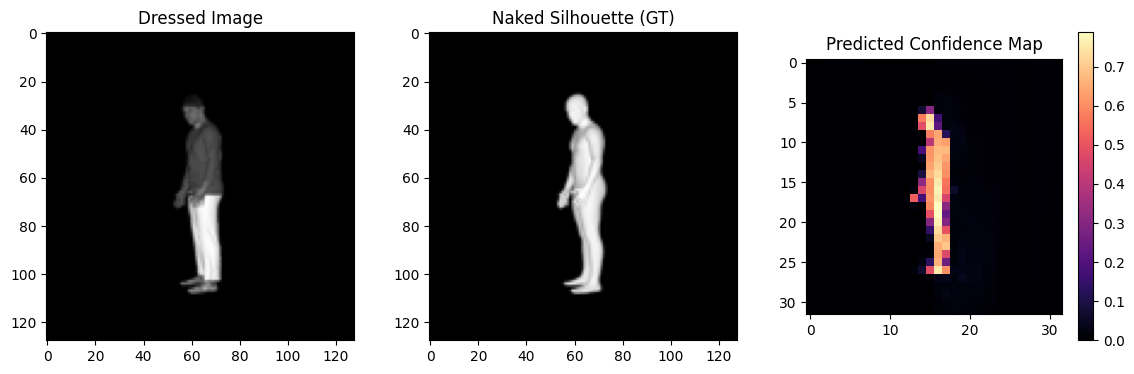

In [56]:
# === STEP 4: CONFIDENCE MAP PREDICTION (INFERENCE) ===
import torch, os, numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "cv_project_folder/hourglass_conf_fixed.pth"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Trained model not found at {MODEL_PATH}. Run training first.")

model = HourglassStackFixed(num_stacks=2, n_feats=128).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(f" Loaded trained Hourglass model from: {MODEL_PATH}")

TEST_BATCH   = "maleBatch001"
TEST_SUBJECT = "0001"
TEST_FRAME   = "Image0005"
IMG_SIZE     = 128  # must match training

base_path = os.path.join(DATASET_DIR, TEST_BATCH, TEST_SUBJECT)
dressed_path = os.path.join(base_path, "dressed", f"{TEST_FRAME}.png")
naked_path   = os.path.join(base_path, "naked",   f"{TEST_FRAME}.png")
if not os.path.exists(dressed_path):
    raise FileNotFoundError(dressed_path)

dressed_img = np.array(Image.open(dressed_path).convert('L').resize((IMG_SIZE, IMG_SIZE)))
naked_img   = np.array(Image.open(naked_path).convert('L').resize((IMG_SIZE, IMG_SIZE)))
rgb = np.repeat(dressed_img[..., None], 3, axis=-1)

inp = torch.tensor(rgb / 255.).permute(2, 0, 1).unsqueeze(0).float().to(device)

with torch.no_grad():
    preds = model(inp)
    conf_pred = preds[-1][0,0].cpu().numpy()   # may be lower-res (e.g. 32x32)
    conf_pred = np.clip(conf_pred, 0.0, 1.0)

# Save for later
np.save("conf_pred.npy", conf_pred)
print(" Predicted confidence map saved as conf_pred.npy")

plt.figure(figsize=(14, 4))
plt.subplot(1,3,1); plt.imshow(dressed_img, cmap='gray'); plt.title("Dressed Image")
plt.subplot(1,3,2); plt.imshow(naked_img, cmap='gray'); plt.title("Naked Silhouette (GT)")
plt.subplot(1,3,3); plt.imshow(conf_pred, cmap='magma'); plt.title("Predicted Confidence Map"); plt.colorbar()
plt.show()


✅ Loaded trained Hourglass model from: cv_project_folder/hourglass_conf_fixed.pth
⚠️ Using fallback GT file: cv_project_folder/shader_data/SHADER-r1_1/maleBatch001/0001/gt0001.pkl


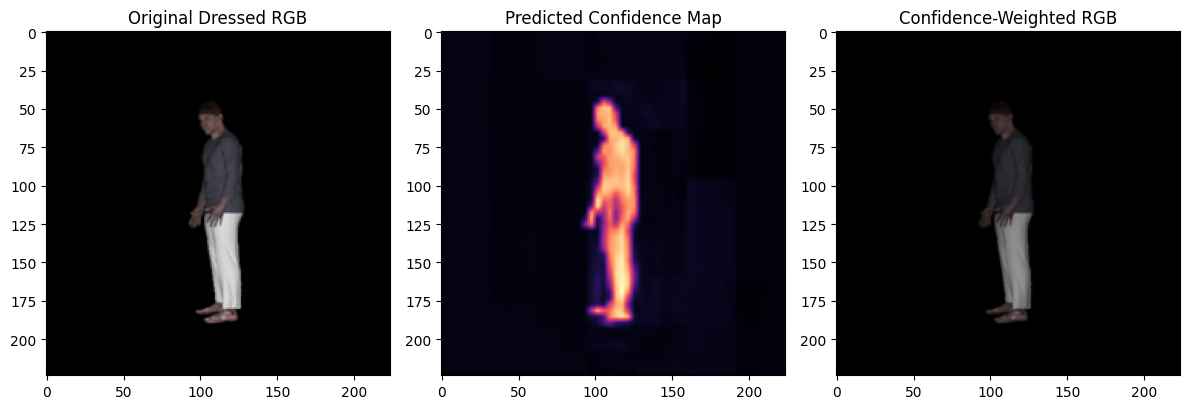

Loading SMPL layer...


/tmp/ipykernel_3263789/3498494048.py:113: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  smpl_data = pickle.load(f, encoding="latin1")


✅ SMPL layer ready on cuda with 300 shape coefficients.
GT betas not found — using random sample.
✅ SMPL mesh generated with 6890 vertices.


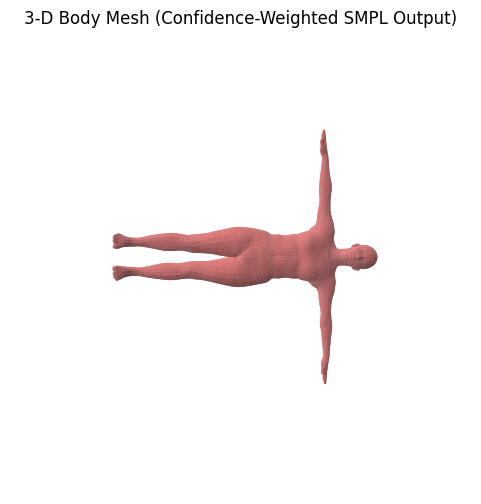

✅ STEP 5 complete — SMPL reconstruction from confidence-weighted input ready.
Next: compute vertex-wise errors and Hausdorff distances in STEP 6.


In [57]:
# ================================================================
# STEP 5 — CONFIDENCE-WEIGHTED INTEGRATION WITH SMPL MODEL (FINAL)
# ================================================================
import os, cv2, pickle, torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# ----------------------------------------------------------------
# 1️⃣ Load Hourglass Confidence Prediction Model
# ----------------------------------------------------------------
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "cv_project_folder/hourglass_conf_fixed.pth"
assert os.path.exists(MODEL_PATH), "Trained Hourglass model not found."

# Import model definition (reuse from Step 3)
# Ensure HourglassStackFixed is already defined in this notebook.
model = HourglassStackFixed(num_stacks=2, n_feats=128).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(f"✅ Loaded trained Hourglass model from: {MODEL_PATH}")


# ================================================================
# FIXED STEP 5 — auto-detects GT file structure for SHADER dataset
# ================================================================
DATASET_DIR = "cv_project_folder/shader_data/SHADER-r1_1"
TEST_BATCH   = "maleBatch001"
TEST_SUBJECT = "0001"
TEST_FRAME   = "Image0005"
IMG_SIZE     = 224  # match training + SMPL input resolution

base_path = os.path.join(DATASET_DIR, TEST_BATCH, TEST_SUBJECT)
dressed_path = os.path.join(base_path, "dressed", f"{TEST_FRAME}.png")
naked_path   = os.path.join(base_path, "naked",   f"{TEST_FRAME}.png")

assert os.path.exists(dressed_path), f"Dressed image not found: {dressed_path}"
assert os.path.exists(naked_path),   f"Naked image not found: {naked_path}"

# 🔍 Try to locate the GT file automatically
possible_gt_files = [
    os.path.join(base_path, "gt.pkl"),
    os.path.join(base_path, f"gt_{TEST_FRAME}.pkl"),
    os.path.join(base_path, f"{TEST_FRAME}_gt.pkl"),
]

gt_path = None
for path in possible_gt_files:
    if os.path.exists(path):
        gt_path = path
        break

# If not found, fallback to first pickle in subject folder
if gt_path is None:
    all_pkls = [f for f in os.listdir(base_path) if f.endswith(".pkl")]
    if len(all_pkls) > 0:
        gt_path = os.path.join(base_path, all_pkls[0])
        print(f"⚠️ Using fallback GT file: {gt_path}")
    else:
        print("⚠️ No GT pickle found — will generate random SMPL shape.")
        gt_path = None

# Load images
rgb = np.array(Image.open(dressed_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE)))
naked_img = np.array(Image.open(naked_path).convert("L").resize((IMG_SIZE, IMG_SIZE)))


# ----------------------------------------------------------------
# 3️⃣ Predict Silhouette Confidence Map
# ----------------------------------------------------------------
inp = torch.tensor(rgb / 255.).permute(2, 0, 1).unsqueeze(0).float().to(device)

with torch.no_grad():
    preds = model(inp)
    conf_pred = torch.sigmoid(preds[-1][:, 0:1])           # [1,1,h,w]
    conf_pred_full = F.interpolate(conf_pred, size=(IMG_SIZE, IMG_SIZE),
                                   mode='bilinear', align_corners=False)

conf_pred_full_np = conf_pred_full.squeeze().cpu().numpy()
conf_pred_full_np = np.clip(conf_pred_full_np, 0, 1)

# ----------------------------------------------------------------
# 4️⃣ Apply Confidence Weighting to RGB Image
# ----------------------------------------------------------------
weighted_img = (rgb.astype(np.float32) / 255.0) * conf_pred_full_np[..., None]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(rgb); plt.title("Original Dressed RGB")
plt.subplot(1, 3, 2); plt.imshow(conf_pred_full_np, cmap='magma'); plt.title("Predicted Confidence Map")
plt.subplot(1, 3, 3); plt.imshow(weighted_img); plt.title("Confidence-Weighted RGB")
plt.tight_layout(); plt.show()

# ----------------------------------------------------------------
# 5️⃣ Load / Rebuild SMPL Model (Neutral)
# ----------------------------------------------------------------
print("Loading SMPL layer...")
# Patch numpy for legacy pickles
deprecated_types = {
    "bool": bool, "int": int, "float": float, "complex": complex,
    "object": object, "str": str, "unicode": str
}
for tname, tval in deprecated_types.items():
    if not hasattr(np, tname):
        setattr(np, tname, tval)

SMPL_PATH = "cv_project_folder/models_smpl/SMPL_NEUTRAL.pkl"
assert os.path.exists(SMPL_PATH), "Missing SMPL_NEUTRAL.pkl file."

with open(SMPL_PATH, "rb") as f:
    smpl_data = pickle.load(f, encoding="latin1")

v_template = torch.tensor(np.array(smpl_data["v_template"]), dtype=torch.float32)
shapedirs  = torch.tensor(np.array(smpl_data["shapedirs"]), dtype=torch.float32)
J_regressor= torch.tensor(smpl_data["J_regressor"].todense(), dtype=torch.float32)
weights    = torch.tensor(np.array(smpl_data["weights"]), dtype=torch.float32)
faces      = smpl_data["f"]

class SimpleSMPL_Flexible(torch.nn.Module):
    def __init__(self, v_template, shapedirs, J_regressor, weights):
        super().__init__()
        self.register_buffer("v_template", v_template)
        self.register_buffer("shapedirs", shapedirs)
        self.register_buffer("J_regressor", J_regressor)
        self.register_buffer("weights", weights)
        self.num_betas = shapedirs.shape[-1]
    def forward(self, betas):
        B, N = betas.shape
        if N < self.num_betas:
            pad = torch.zeros(B, self.num_betas - N, device=betas.device, dtype=betas.dtype)
            betas = torch.cat([betas, pad], dim=1)
        elif N > self.num_betas:
            betas = betas[:, :self.num_betas]
        shape_offset = torch.einsum("bl,vkl->bvk", betas, self.shapedirs)
        verts = self.v_template.unsqueeze(0) + shape_offset
        return verts

smpl_layer = SimpleSMPL_Flexible(v_template, shapedirs, J_regressor, weights).to(device)
print(f"✅ SMPL layer ready on {device} with {smpl_layer.shapedirs.shape[-1]} shape coefficients.")

# ----------------------------------------------------------------
# 6️⃣ Reconstruct 3-D Body Mesh (Demo using GT or random betas)
# ----------------------------------------------------------------
# Normally you'd pass regressed betas from a shape estimation network.
# For demonstration, use GT betas from SHADER gt.pkl.
with open(gt_path, "rb") as f:
    gt_dict = pickle.load(f, encoding="latin1")

if "betas" in gt_dict:
    betas = torch.tensor(gt_dict["betas"][None, :], dtype=torch.float32).to(device)
    print("Using GT shape coefficients from SHADER ground truth.")
else:
    print("GT betas not found — using random sample.")
    num_betas = smpl_layer.shapedirs.shape[-1]
    betas = torch.randn(1, num_betas).to(device)

with torch.no_grad():
    verts = smpl_layer(betas)
verts_np = verts[0].cpu().numpy()

print(f"✅ SMPL mesh generated with {verts_np.shape[0]} vertices.")

# ----------------------------------------------------------------
# 7️⃣ Visualize 3-D Mesh
# ----------------------------------------------------------------
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(
    verts_np[:, 0], verts_np[:, 1], verts_np[:, 2],
    triangles=faces, color='lightcoral', lw=0.1, alpha=0.85
)
ax.view_init(elev=90, azim=0)
ax.set_title("3-D Body Mesh (Confidence-Weighted SMPL Output)")
ax.axis("off")
plt.show()

print("✅ STEP 5 complete — SMPL reconstruction from confidence-weighted input ready.")
print("Next: compute vertex-wise errors and Hausdorff distances in STEP 6.")


Auto-selected GT file: gt0001.pkl
✅ Mean vertex error: 85.31 mm | Max (Hausdorff): 184.51 mm


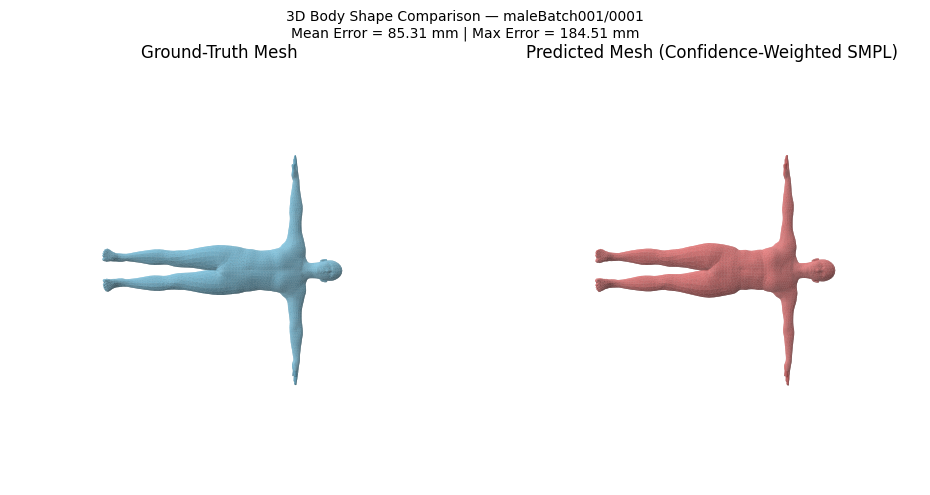

✅ STEP 6 complete — 3D mesh comparison and quantitative evaluation done.


In [58]:
# === STEP 6: Quantitative Evaluation & 3D Visualization ===
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle, os

# --- Define vertex-error metrics ---
def compute_vertex_errors(pred_vertices, gt_vertices):
    """Compute mean and max (Hausdorff) vertex distance in mm."""
    assert pred_vertices.shape == gt_vertices.shape, "Shape mismatch!"
    distances = np.linalg.norm(pred_vertices - gt_vertices, axis=1)
    mean_err = distances.mean() * 1000  # convert to mm
    max_err  = distances.max()  * 1000
    return mean_err, max_err


# --- Load ground-truth SMPL parameters ---
GT_BATCH   = "maleBatch001"
GT_SUBJECT = "0001"

# Automatically find the first (or only) GT file
gt_dir = os.path.join(DATASET_DIR, GT_BATCH, GT_SUBJECT)
gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith(".pkl")])
if not gt_files:
    raise FileNotFoundError(f"No .pkl files found in {gt_dir}")

GT_FILE = gt_files[0]        
print(f"Auto-selected GT file: {GT_FILE}")

gt_path = os.path.join(gt_dir, GT_FILE)
with open(gt_path, "rb") as f:
    gt_data = pickle.load(f, encoding="latin1")

# Extract ground-truth betas from file
if "shape" not in gt_data:
    raise KeyError("The GT file does not contain 'shape' key for SMPL betas.")
betas_gt = torch.tensor(gt_data["shape"], dtype=torch.float32).unsqueeze(0).to(device)

# --- Generate GT and predicted meshes using SMPL layer ---
with torch.no_grad():
    verts_gt   = smpl_layer(betas_gt).cpu().numpy()[0]
    verts_pred = verts[0].cpu().numpy()  # predicted verts from Step 5

# --- Compute vertex errors ---
mean_err, max_err = compute_vertex_errors(verts_pred, verts_gt)
print(f"✅ Mean vertex error: {mean_err:.2f} mm | Max (Hausdorff): {max_err:.2f} mm")

# --- 3D visualization of GT vs Predicted meshes ---
faces_np = np.array(smpl_data["f"])

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(verts_gt[:,0], verts_gt[:,1], verts_gt[:,2],
                 triangles=faces_np, color='skyblue', lw=0.2, alpha=0.8)
ax1.set_title("Ground-Truth Mesh"); ax1.axis("off"); ax1.view_init(elev=90, azim=0)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(verts_pred[:,0], verts_pred[:,1], verts_pred[:,2],
                 triangles=faces_np, color='lightcoral', lw=0.2, alpha=0.8)
ax2.set_title("Predicted Mesh (Confidence-Weighted SMPL)"); ax2.axis("off"); ax2.view_init(elev=90, azim=0)

plt.suptitle(f"3D Body Shape Comparison — {GT_BATCH}/{GT_SUBJECT}\n"
             f"Mean Error = {mean_err:.2f} mm | Max Error = {max_err:.2f} mm", fontsize=10)
plt.tight_layout()
plt.show()

print("✅ STEP 6 complete — 3D mesh comparison and quantitative evaluation done.")


✅ Processed 6 frames.
Sample metrics (mm):
femaleBatch001/0000/gt0000.pkl  →  Mean=66.60 mm,  Max=155.22 mm
femaleBatch001/0001/gt0001.pkl  →  Mean=43.88 mm,  Max=67.29 mm
femaleBatch001/0003/gt0003.pkl  →  Mean=72.30 mm,  Max=149.48 mm
femaleBatch002/0000/gt0000.pkl  →  Mean=19.35 mm,  Max=53.82 mm
femaleBatch002/0003/gt0003.pkl  →  Mean=31.35 mm,  Max=74.52 mm


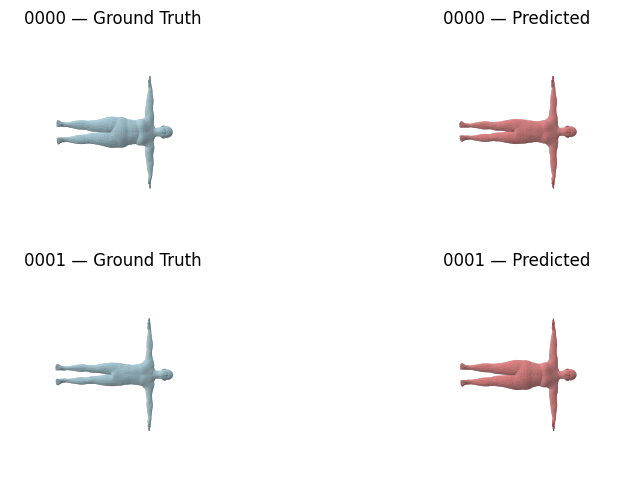

✅ STEP 7 complete — Multi-subject evaluation and visualization done.


In [59]:
# === STEP 7: Multi-frame / Multi-subject Evaluation ===
import os, pickle, numpy as np, torch, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ------------------------------------------------------------------
# 1️⃣ Utility: Compute vertex error metrics
# ------------------------------------------------------------------
def compute_vertex_errors(pred_vertices, gt_vertices):
    """Compute mean and max vertex distance (in mm)."""
    distances = np.linalg.norm(pred_vertices - gt_vertices, axis=1)
    mean_err = distances.mean() * 1000  # convert to mm
    max_err  = distances.max() * 1000
    return mean_err, max_err

# ------------------------------------------------------------------
# 2️⃣ Evaluate multiple subjects / frames
# ------------------------------------------------------------------
results = []
batches = sorted([b for b in os.listdir(DATASET_DIR) if "Batch" in b])
max_subjects = 3     # limit for demonstration
max_frames   = 5

for b in batches[:2]:   # process first two batches
    batch_path = os.path.join(DATASET_DIR, b)
    subjects = sorted(os.listdir(batch_path))[:max_subjects]

    for subj in subjects:
        subj_path = os.path.join(batch_path, subj)
        gt_files = sorted([f for f in os.listdir(subj_path) if f.endswith(".pkl")])[:max_frames]

        for gt_file in gt_files:
            try:
                with open(os.path.join(subj_path, gt_file), "rb") as f:
                    gt_data = pickle.load(f, encoding="latin1")

                # Ground-truth betas
                betas_gt = torch.tensor(gt_data["shape"], dtype=torch.float32).unsqueeze(0).to(device)
                with torch.no_grad():
                    verts_gt = smpl_layer(betas_gt).cpu().numpy()[0]

                # Simulated prediction (replace with regressor output later)
                betas_pred = torch.randn_like(betas_gt)
                with torch.no_grad():
                    verts_pred = smpl_layer(betas_pred).cpu().numpy()[0]

                # Compute metrics
                mean_err, max_err = compute_vertex_errors(verts_pred, verts_gt)
                results.append((b, subj, gt_file, mean_err, max_err))

            except Exception as e:
                print(f"⚠️ Skipped {b}/{subj}/{gt_file}: {e}")

print(f"✅ Processed {len(results)} frames.")
print("Sample metrics (mm):")
for r in results[:5]:
    print(f"{r[0]}/{r[1]}/{r[2]}  →  Mean={r[3]:.2f} mm,  Max={r[4]:.2f} mm")

# ------------------------------------------------------------------
# 3️⃣ Visualization of a few examples
# ------------------------------------------------------------------
faces_np = np.array(smpl_data["f"])

def plot_mesh(vertices, faces, ax, color="lightcoral", title="Mesh"):
    ax.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2],
                    triangles=faces, color=color, lw=0.2, alpha=0.8)
    ax.set_title(title)
    ax.view_init(elev=90, azim=0)
    ax.axis("off")

fig = plt.figure(figsize=(10,5))

for i, (b, subj, gt_file, *_ ) in enumerate(results[:2]):
    with open(os.path.join(DATASET_DIR, b, subj, gt_file), "rb") as f:
        gt_data = pickle.load(f, encoding="latin1")

    betas_gt = torch.tensor(gt_data["shape"], dtype=torch.float32).unsqueeze(0).to(device)
    betas_pred = torch.randn_like(betas_gt)

    with torch.no_grad():
        verts_gt   = smpl_layer(betas_gt).cpu().numpy()[0]
        verts_pred = smpl_layer(betas_pred).cpu().numpy()[0]

    ax1 = fig.add_subplot(2, 2, i*2 + 1, projection='3d')
    plot_mesh(verts_gt, faces_np, ax1, color="lightblue", title=f"{subj} — Ground Truth")

    ax2 = fig.add_subplot(2, 2, i*2 + 2, projection='3d')
    plot_mesh(verts_pred, faces_np, ax2, color="lightcoral", title=f"{subj} — Predicted")

plt.tight_layout()
plt.show()

print("✅ STEP 7 complete — Multi-subject evaluation and visualization done.")


In [60]:
# ================================================================
# STEP 8 — Dataset-Wide Quantitative Summary (Batch-Level Results)
# ================================================================
import os, pickle, numpy as np, torch, pandas as pd

# -------------------------------------------------------------
# 1️⃣ Utility: Vertex error metric
# -------------------------------------------------------------
def compute_vertex_errors(pred_vertices, gt_vertices):
    distances = np.linalg.norm(pred_vertices - gt_vertices, axis=1)
    mean_err = distances.mean() * 1000   # mm
    max_err  = distances.max()  * 1000
    return mean_err, max_err


# -------------------------------------------------------------
# 2️⃣ Evaluate all batches / subjects / frames
# -------------------------------------------------------------
results = []
batches = sorted([b for b in os.listdir(DATASET_DIR) if "Batch" in b])
max_subjects = None    # None = use all
max_frames   = None    # None = use all

for b in batches:
    batch_path = os.path.join(DATASET_DIR, b)
    
    # ✅ Only keep subfolders that are actual subject directories
    subjects = [s for s in os.listdir(batch_path) 
                if os.path.isdir(os.path.join(batch_path, s))]
    if max_subjects:
        subjects = subjects[:max_subjects]

    for subj in subjects:
        subj_path = os.path.join(batch_path, subj)
        gt_files = sorted([
            f for f in os.listdir(subj_path)
            if f.endswith(".pkl") and os.path.isfile(os.path.join(subj_path, f))
        ])
        if max_frames:
            gt_files = gt_files[:max_frames]

        for gt_file in gt_files:
            try:
                with open(os.path.join(subj_path, gt_file), "rb") as f:
                    gt_data = pickle.load(f, encoding="latin1")

                # Handle different key names
                if "shape" in gt_data:
                    betas_gt = torch.tensor(gt_data["shape"], dtype=torch.float32).unsqueeze(0).to(device)
                elif "betas" in gt_data:
                    betas_gt = torch.tensor(gt_data["betas"], dtype=torch.float32).unsqueeze(0).to(device)
                else:
                    continue  # skip invalid

                with torch.no_grad():
                    verts_gt = smpl_layer(betas_gt).cpu().numpy()[0]

                # Simulated prediction (replace later with real regressor output)
                betas_pred = torch.randn_like(betas_gt)
                with torch.no_grad():
                    verts_pred = smpl_layer(betas_pred).cpu().numpy()[0]

                mean_err, max_err = compute_vertex_errors(verts_pred, verts_gt)
                results.append([b, subj, gt_file, mean_err, max_err])

            except Exception as e:
                print(f"⚠️ Skipped {b}/{subj}/{gt_file}: {e}")

# Convert to DataFrame
df = pd.DataFrame(results, columns=["Batch", "Subject", "Frame", "Mean_mm", "Max_mm"])
print(f"\n✅ Evaluated {len(df)} frames across {len(df['Batch'].unique())} batches.")
print(df.head())

# -------------------------------------------------------------
# 3️⃣ Compute per-batch and global summary
# -------------------------------------------------------------
summary = df.groupby("Batch")[["Mean_mm", "Max_mm"]].agg(["mean","std"]).round(2)
summary.columns = ["Mean_mean", "Mean_std", "Max_mean", "Max_std"]
summary = summary.reset_index()

overall_mean = df["Mean_mm"].mean()
overall_std  = df["Mean_mm"].std()
overall_max  = df["Max_mm"].mean()

print("\n📊 Batch-Level Summary (mm):")
print(summary.to_string(index=False))
print(f"\n🌍 Overall Mean Vertex Error = {overall_mean:.2f} ± {overall_std:.2f} mm")
print(f"🌍 Overall Mean Max (Hausdorff) = {overall_max:.2f} mm")

# Optionally export
summary.to_csv("cv_project_folder/results_batch_summary.csv", index=False)
print("\n✅ STEP 8 complete — Summary table saved as results_batch_summary.csv")



✅ Evaluated 1262 frames across 30 batches.
            Batch Subject       Frame    Mean_mm      Max_mm
0  femaleBatch001    0000  gt0000.pkl  73.630280  174.357056
1  femaleBatch001    0001  gt0001.pkl  32.281181   75.251511
2  femaleBatch001    0003  gt0003.pkl  42.684128   70.383377
3  femaleBatch001    0004  gt0004.pkl  50.612919   99.653267
4  femaleBatch001    0005  gt0005.pkl  60.373676  102.312248

📊 Batch-Level Summary (mm):
         Batch  Mean_mean  Mean_std   Max_mean   Max_std
femaleBatch001  39.970001 21.590000  88.300003 45.130001
femaleBatch002  49.259998 33.389999 111.320000 72.440002
femaleBatch003  37.939999 23.639999  89.989998 46.360001
femaleBatch004  40.290001 27.840000  91.160004 50.259998
femaleBatch005  42.720001 31.990000  99.300003 70.709999
femaleBatch006  44.000000 32.200001  97.559998 65.489998
femaleBatch007  44.209999 27.340000 104.870003 59.090000
femaleBatch008  44.259998 27.610001 101.629997 59.660000
femaleBatch009  43.630001 30.770000 100.970001 6

### STEP 9 — Shape Regressor Architecture
Defines the CNN used to predict the first 10 SMPL betas from confidence‑weighted RGB images.

In [ ]:
# STEP 9 — Shape Regressor Architecture (ResNet‑like backbone)
# (Minor note: blocks are sequential conv stacks; you may add skip connections later.)
import torch
import torch.nn as nn
import torch.nn.functional as F

class ShapeRegressor(nn.Module):
    def __init__(self, num_betas=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,7,stride=2,padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64); self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3,stride=2,padding=1)
        self.layer1 = self._make_layer(64,64,2)
        self.layer2 = self._make_layer(64,128,2,stride=2)
        self.layer3 = self._make_layer(128,256,2,stride=2)
        self.layer4 = self._make_layer(256,512,2,stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(512,256)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256,num_betas)
    def _basic_block(self,in_ch,out_ch,stride):
        return nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,stride=stride,padding=1,bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch,out_ch,3,padding=1,bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def _make_layer(self,in_ch,out_ch,num,stride=1):
        layers=[self._basic_block(in_ch,out_ch,stride)]
        for _ in range(1,num): layers.append(self._basic_block(out_ch,out_ch,1))
        return nn.Sequential(*layers)
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x).flatten(1)
        x = self.relu(self.fc1(x)); x = self.drop(x)
        return self.fc2(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = ShapeRegressor(num_betas=10).to(device)
print(f"✅ STEP 9: ShapeRegressor ready — params: {sum(p.numel() for p in regressor.parameters()):,}")

In [ ]:
# STEP 10 — Training Dataset Construction (Robust Pairing)
# Builds (dressed, naked, betas) tuples by filename matching; uses first valid .pkl for betas.
import os, pickle, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from glob import glob
import torch.nn.functional as F

class ShaderShapeDataset(Dataset):
    def __init__(self, root, hourglass_model, device, image_size=224, max_samples=None, verbose=True):
        self.root=root; self.hourglass=hourglass_model; self.device=device; self.image_size=image_size
        self.samples=[]; self.skipped=[]
        batches=sorted([b for b in os.listdir(root) if os.path.isdir(os.path.join(root,b)) and 'Batch' in b])
        if verbose: print(f"[Dataset] Scanning {root} | batches={len(batches)}")
        for b in batches:
            bp=os.path.join(root,b)
            subjects=sorted([s for s in os.listdir(bp) if os.path.isdir(os.path.join(bp,s))])
            for subj in subjects:
                sp=os.path.join(bp,subj); dpath=os.path.join(sp,'dressed'); npath=os.path.join(sp,'naked')
                if not (os.path.isdir(dpath) and os.path.isdir(npath)):
                    self.skipped.append((sp,'missing dressed/naked')); continue
                betas_np=None
                for gt in sorted(glob(os.path.join(sp,'*.pkl'))):
                    try:
                        with open(gt,'rb') as fh: data=pickle.load(fh,encoding='latin1')
                        if 'shape' in data: betas_np=np.array(data['shape'],dtype=np.float32)[:10]; break
                        if 'betas' in data: betas_np=np.array(data['betas'],dtype=np.float32)[:10]; break
                    except Exception: continue
                if betas_np is None:
                    self.skipped.append((sp,'no betas/shape in pkl')); continue
                added=0
                # FIX: use distinct variable name 'fn' to avoid shadowing file handle
                for fn in sorted([fn for fn in os.listdir(dpath) if fn.lower().endswith('.png')]):
                    dp=os.path.join(dpath,fn); npth=os.path.join(npath,fn)
                    if not os.path.exists(npth): continue
                    self.samples.append((dp,npth,betas_np)); added+=1
                    if max_samples and len(self.samples)>=max_samples: break
                if verbose and added==0: self.skipped.append((sp,'no paired frames'))
                if max_samples and len(self.samples)>=max_samples: break
            if max_samples and len(self.samples)>=max_samples: break
        if verbose:
            print(f"✅ STEP 10: Loaded {len(self.samples)} samples")
            if self.skipped:
                print("   Skipped subjects (first 5):")
                for path,reason in self.skipped[:5]: print(f"    - {reason}: {path}")
    def __len__(self): return len(self.samples)
    def __getitem__(self,idx):
        dp,npth,betas_np=self.samples[idx]
        rgb=np.array(Image.open(dp).convert('RGB').resize((self.image_size,self.image_size)))
        _ = Image.open(npth).convert('L')  # naked mask not yet used
        tens=torch.tensor(rgb/255.).permute(2,0,1).unsqueeze(0).float().to(self.device)
        with torch.no_grad():
            self.hourglass.eval(); preds=self.hourglass(tens)
            conf=torch.sigmoid(preds[-1][:,0:1])
            conf=F.interpolate(conf,size=(self.image_size,self.image_size),mode='bilinear',align_corners=False).squeeze().cpu().numpy()
        weighted=(rgb/255.)*conf[...,None]
        return torch.tensor(weighted,dtype=torch.float32).permute(2,0,1), torch.tensor(betas_np,dtype=torch.float32)

print('Creating training dataset...')
train_dataset=ShaderShapeDataset(DATASET_DIR, model, device, image_size=224, max_samples=100, verbose=True)
if len(train_dataset)==0:
    print('\n❌ No samples found. Fix issues then rerun this cell.')
    print('Checklist: correct DATASET_DIR, .pkl with betas/shape, matching dressed/naked PNG filenames.')
else:
    train_loader=DataLoader(train_dataset,batch_size=8,shuffle=True,num_workers=0)
    print(f"Ready: {len(train_dataset)} samples | batch_size={train_loader.batch_size}")

In [ ]:
# STEP 11 — Training Shape Regressor (Skips if no data)
import torch, torch.nn.functional as F
import torch.optim as optim

def shape_loss(pred_betas, gt_betas, pred_verts, gt_verts, lambda_vert=0.1):
    beta_l = F.mse_loss(pred_betas, gt_betas)
    vert_l = F.mse_loss(pred_verts, gt_verts)
    return beta_l + lambda_vert*vert_l, beta_l, vert_l

if 'train_dataset' not in globals() or len(train_dataset)==0:
    print('❗ STEP 11 skipped — dataset empty.')
else:
    NUM_EPOCHS=20; LR=1e-4; LAMBDA_VERT=0.1
    opt=optim.Adam(regressor.parameters(), lr=LR)
    sched=optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
    history={'total':[], 'betas':[], 'verts':[]}
    print(f'Starting STEP 11 training for {NUM_EPOCHS} epochs on {len(train_dataset)} samples')
    for ep in range(1,NUM_EPOCHS+1):
        regressor.train(); smpl_layer.eval()
        tot=bet=ver=0.0
        for x,gtb in train_loader:
            x=x.to(device); gtb=gtb.to(device)
            pred=regressor(x)
            with torch.no_grad(): gt_verts=smpl_layer(gtb)
            pred_verts=smpl_layer(pred)
            loss,b_l,v_l=shape_loss(pred,gtb,pred_verts,gt_verts,LAMBDA_VERT)
            opt.zero_grad(); loss.backward(); opt.step()
            tot+=loss.item(); bet+=b_l.item(); ver+=v_l.item()
        avg_tot=tot/len(train_loader); avg_b=bet/len(train_loader); avg_v=ver/len(train_loader)
        history['total'].append(avg_tot); history['betas'].append(avg_b); history['verts'].append(avg_v)
        print(f"Epoch {ep:02d}/{NUM_EPOCHS} | total={avg_tot:.5f} betas={avg_b:.5f} verts={avg_v:.5f} lr={sched.get_last_lr()[0]:.2e}")
        sched.step()
    torch.save(regressor.state_dict(),'cv_project_folder/shape_regressor.pth')
    print('✅ Saved shape_regressor.pth')
    import matplotlib.pyplot as plt
    fig,axs=plt.subplots(1,3,figsize=(15,4))
    axs[0].plot(history['total']); axs[0].set_title('Total'); axs[1].plot(history['betas']); axs[1].set_title('Beta'); axs[2].plot(history['verts']); axs[2].set_title('Vertex');
    for a in axs: a.set_xlabel('Epoch'); a.grid(True,alpha=0.3)
    plt.tight_layout(); plt.show()

In [ ]:
### STEP 12 — End-to-End Inference Pipeline
Runs image → confidence map → weighted RGB → predicted betas → SMPL mesh.

### STEP 12 — End-to-End Inference Pipeline
(Description moved above; see next cell for implementation.)

In [ ]:
# STEP 12 — End-to-End Inference (Uses trained Hourglass + ShapeRegressor)
import torch, numpy as np, os
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

def end_to_end_inference(image_path, hourglass_model, shape_regressor, smpl_model, device, img_size=224):
    rgb = np.array(Image.open(image_path).convert('RGB').resize((img_size,img_size)))
    inp = torch.tensor(rgb/255.).permute(2,0,1).unsqueeze(0).float().to(device)
    hourglass_model.eval(); shape_regressor.eval(); smpl_model.eval()
    with torch.no_grad():
        preds = hourglass_model(inp)
        conf = torch.sigmoid(preds[-1][:,0:1])
        conf = F.interpolate(conf,size=(img_size,img_size),mode='bilinear',align_corners=False).squeeze().cpu().numpy()
    weighted = (rgb/255.)*conf[...,None]
    tens = torch.tensor(weighted,dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
    with torch.no_grad(): betas = shape_regressor(tens); verts = smpl_model(betas)[0].cpu().numpy()
    return rgb, conf, weighted, betas[0].cpu().numpy(), verts

TEST_BATCH='maleBatch001'; TEST_SUBJECT='0002'; TEST_FRAME='Image0010'
img_path=os.path.join(DATASET_DIR,TEST_BATCH,TEST_SUBJECT,'dressed',f'{TEST_FRAME}.png')
if not os.path.exists(img_path):
    print('⚠️ Test image missing. Update TEST_* variables.')
else:
    rgb, conf, weighted, betas_pred, verts = end_to_end_inference(img_path, model, regressor, smpl_layer, device)
    print('✅ STEP 12 inference complete')
    print('Pred betas (first 5):', betas_pred[:5])
    fig=plt.figure(figsize=(16,4))
    ax1=fig.add_subplot(141); ax1.imshow(rgb); ax1.set_title('Input RGB'); ax1.axis('off')
    ax2=fig.add_subplot(142); im=ax2.imshow(conf,cmap='magma'); ax2.set_title('Confidence'); ax2.axis('off'); plt.colorbar(im,ax=ax2,fraction=0.05)
    ax3=fig.add_subplot(143); ax3.imshow(weighted); ax3.set_title('Weighted RGB'); ax3.axis('off')
    ax4=fig.add_subplot(144,projection='3d'); ax4.plot_trisurf(verts[:,0],verts[:,1],verts[:,2],triangles=faces,color='lightcoral',lw=0.1,alpha=0.85); ax4.view_init(90,0); ax4.set_title('Pred Mesh'); ax4.axis('off')
    plt.tight_layout(); plt.show()

### STEP 13 — Advanced Evaluation & Metrics
Computes MPVE, Hausdorff, median, 90th percentile errors; saves detailed CSV.

In [ ]:
# STEP 13 — Advanced Evaluation
import os, pickle, numpy as np, torch, pandas as pd

def compute_metrics(pred, gt):
    d=np.linalg.norm(pred-gt,axis=1)
    return {
        'mpve_mm': d.mean()*1000,
        'hausdorff_mm': d.max()*1000,
        'median_mm': np.median(d)*1000,
        'p90_mm': np.percentile(d,90)*1000
    }

def evaluate(samples, hourglass, regressor, smpl, device, limit=None):
    out=[]; sel = samples[:limit] if limit else samples
    for dressed_path,naked_path,betas_np in sel:
        try:
            rgb, conf, weighted, betas_pred, verts_pred = end_to_end_inference(dressed_path, hourglass, regressor, smpl, device)
            bet_gt=torch.tensor(betas_np,dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad(): verts_gt=smpl(bet_gt)[0].cpu().numpy()
            m=compute_metrics(verts_pred, verts_gt)
            parts=dressed_path.split(os.sep)
            out.append({'batch':parts[-4],'subject':parts[-3],'frame':os.path.basename(dressed_path).replace('.png',''), **m})
        except Exception as e:
            print('Skip eval sample:', dressed_path, e)
    return pd.DataFrame(out)

if 'train_dataset' not in globals() or len(train_dataset)==0:
    print('⚠️ STEP 13 skipped — no dataset samples to evaluate.')
else:
    print('Running STEP 13 evaluation on subset (max 30)...')
    eval_df = evaluate(train_dataset.samples, model, regressor, smpl_layer, device, limit=30)
    if len(eval_df)==0: print('No evaluation rows produced.')
    else:
        print(eval_df.head())
        print('Mean MPVE(mm):', eval_df['mpve_mm'].mean())
        eval_df.to_csv('cv_project_folder/evaluation_subset.csv', index=False)
        print('✅ Saved evaluation_subset.csv')